In [1]:
!pip install -q torch-scatter torch-sparse torch-cluster torch-spline-conv torch-geometric -f https://data.pyg.org/whl/torch-2.0.0+cu118.html


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 22.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 15.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 11.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 886.5/886.5 kB 11.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 10.8 MB/s eta 0:00:00


In [11]:
import torch
import matplotlib.pyplot as plt
from torch_geometric.datasets import Planetoid
import torch.nn.functional as F
from torch.nn import Linear
from torch import nn, optim
from torch_geometric.nn import GCNConv
from sklearn.manifold import TSNE

In [2]:
data = Planetoid(root='.', name='Cora')[0]

/usr/local/lib/python3.11/dist-packages/torch_geometric/typing.py:86: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: /usr/local/lib/python3.11/dist-packages/torch_scatter/_version_cuda.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev
  warnings.warn(f"An issue occurred while importing 'torch-scatter'. "
/usr/local/lib/python3.11/dist-packages/torch_geometric/typing.py:97: UserWarning: An issue occurred while importing 'torch-cluster'. Disabling its usage. Stacktrace: /usr/local/lib/python3.11/dist-packages/torch_cluster/_version_cuda.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev
  warnings.warn(f"An issue occurred while importing 'torch-cluster'. "
/usr/local/lib/python3.11/dist-packages/torch_geometric/typing.py:113: UserWarning: An issue occurred while importing 'torch-spline-conv'. Disabling its usage. Stacktrace: /usr/local/lib/python3.11/dist-packages/torch_spline_conv/_version_cuda.so: undefined symbol: _ZN3c1017Registe

### QUESTION 1 Warm-up: Inspecting the Graph

1. Nodes and edges

In [4]:
print(f"Number of nodes: {data.num_nodes}")
print(f"Number of edges: {data.num_edges}")
print(f"Feature dimension: {data.num_node_features}")
print(f"Class distribution: {data.y.bincount()}")

Number of nodes: 2708
Number of edges: 10556
Feature dimension: 1433
Class distribution: tensor([351, 217, 418, 818, 426, 298, 180])


2. Degree Histogram

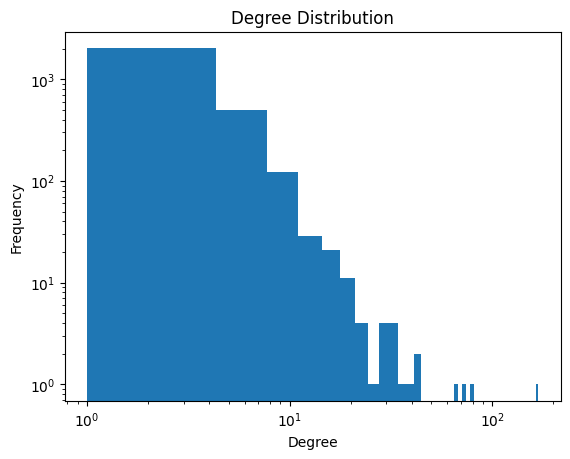

In [5]:
#Histogram
deg = torch.zeros(data.num_nodes, dtype=torch.long)
for i in range(data.edge_index.size(1)):
    deg[data.edge_index[0, i]] += 1
plt.hist(deg.numpy(), bins=50, log=True)
plt.xscale("log")
plt.xlabel("Degree")
plt.ylabel("Frequency")
plt.title("Degree Distribution")
plt.show()


### QUESTION 2 Baseline Without Graph

In [6]:
class LogisticRegression(nn.Module):
    def __init__(self, input_dim, num_classes):
        super().__init__()
        self.linear = Linear(input_dim, num_classes)

    def forward(self, x):
        return self.linear(x)

model = LogisticRegression(data.num_node_features, data.y.max().item() + 1)
optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

def train():
    model.train()
    optimizer.zero_grad()
    out = model(data.x)
    loss = F.cross_entropy(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    return loss.item()

@torch.no_grad()
def test():
    model.eval()
    out = model(data.x)
    pred = out.argmax(dim=1)
    accs = []
    for mask in [data.train_mask, data.val_mask, data.test_mask]:
        correct = pred[mask] == data.y[mask]
        accs.append(int(correct.sum()) / int(mask.sum()))
    return accs

for epoch in range(200):
    loss = train()
    if epoch % 10 == 0:
        train_acc, val_acc, test_acc = test()
        print(f"Epoch {epoch} - Train: {train_acc:.4f}, Val: {val_acc:.4f}, Test: {test_acc:.4f}")

train_acc, val_acc, test_acc = test()
print(f"\nFinal Test Accuracy: {test_acc:.4f}")

Epoch 0 - Train: 0.9143, Val: 0.3260, Test: 0.3040
Epoch 10 - Train: 1.0000, Val: 0.4800, Test: 0.4710
Epoch 20 - Train: 1.0000, Val: 0.4880, Test: 0.4780
Epoch 30 - Train: 1.0000, Val: 0.4780, Test: 0.4810
Epoch 40 - Train: 1.0000, Val: 0.4700, Test: 0.4790
Epoch 50 - Train: 1.0000, Val: 0.4620, Test: 0.4790
Epoch 60 - Train: 1.0000, Val: 0.4640, Test: 0.4720
Epoch 70 - Train: 1.0000, Val: 0.4660, Test: 0.4680
Epoch 80 - Train: 1.0000, Val: 0.4600, Test: 0.4650
Epoch 90 - Train: 1.0000, Val: 0.4600, Test: 0.4660
Epoch 100 - Train: 1.0000, Val: 0.4620, Test: 0.4610
Epoch 110 - Train: 1.0000, Val: 0.4640, Test: 0.4650
Epoch 120 - Train: 1.0000, Val: 0.4640, Test: 0.4640
Epoch 130 - Train: 1.0000, Val: 0.4660, Test: 0.4640
Epoch 140 - Train: 1.0000, Val: 0.4700, Test: 0.4630
Epoch 150 - Train: 1.0000, Val: 0.4680, Test: 0.4630
Epoch 160 - Train: 1.0000, Val: 0.4680, Test: 0.4630
Epoch 170 - Train: 1.0000, Val: 0.4740, Test: 0.4680
Epoch 180 - Train: 1.0000, Val: 0.4780, Test: 0.4720
Epoc

### QUESTION 3 Two-Layer GCN

implementing GCN

In [7]:


class GCN(nn.Module):
    def __init__(self, in_feats, hidden_feats, out_feats):
        super().__init__()
        self.conv1 = GCNConv(in_feats, hidden_feats)
        self.conv2 = GCNConv(hidden_feats, out_feats)
        self.dropout = nn.Dropout(p=0.5)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.conv2(x, edge_index)
        return x

model = GCN(data.num_node_features, 16, data.y.max().item() + 1)
optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

Train for 200 epochs

In [8]:
train_accuracies, val_accuracies, test_accuracies = [], [], []

for epoch in range(200):
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)
    loss = F.cross_entropy(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()

    model.eval()
    pred = out.argmax(dim=1)
    accs = []
    for mask in [data.train_mask, data.val_mask, data.test_mask]:
        correct = pred[mask] == data.y[mask]
        accs.append(int(correct.sum()) / int(mask.sum()))

    train_accuracies.append(accs[0])
    val_accuracies.append(accs[1])
    test_accuracies.append(accs[2])

    if epoch % 10 == 0:
        print(f"Epoch {epoch}: Train={accs[0]:.4f}, Val={accs[1]:.4f}, Test={accs[2]:.4f}")


Epoch 0: Train=0.1071, Val=0.0980, Test=0.1010
Epoch 10: Train=0.9286, Val=0.6380, Test=0.6670
Epoch 20: Train=0.9857, Val=0.7020, Test=0.7200
Epoch 30: Train=0.9857, Val=0.7220, Test=0.7430
Epoch 40: Train=0.9857, Val=0.7440, Test=0.7560
Epoch 50: Train=0.9857, Val=0.7120, Test=0.7500
Epoch 60: Train=1.0000, Val=0.7100, Test=0.7450
Epoch 70: Train=0.9929, Val=0.7640, Test=0.7580
Epoch 80: Train=1.0000, Val=0.7220, Test=0.7400
Epoch 90: Train=1.0000, Val=0.7380, Test=0.7520
Epoch 100: Train=0.9929, Val=0.7060, Test=0.7450
Epoch 110: Train=1.0000, Val=0.7500, Test=0.7500
Epoch 120: Train=0.9929, Val=0.7320, Test=0.7730
Epoch 130: Train=1.0000, Val=0.7240, Test=0.7500
Epoch 140: Train=1.0000, Val=0.7520, Test=0.7600
Epoch 150: Train=1.0000, Val=0.7400, Test=0.7460
Epoch 160: Train=1.0000, Val=0.7320, Test=0.7540
Epoch 170: Train=1.0000, Val=0.7300, Test=0.7700
Epoch 180: Train=0.9929, Val=0.7340, Test=0.7750
Epoch 190: Train=0.9929, Val=0.7540, Test=0.7440


Accuracy curve

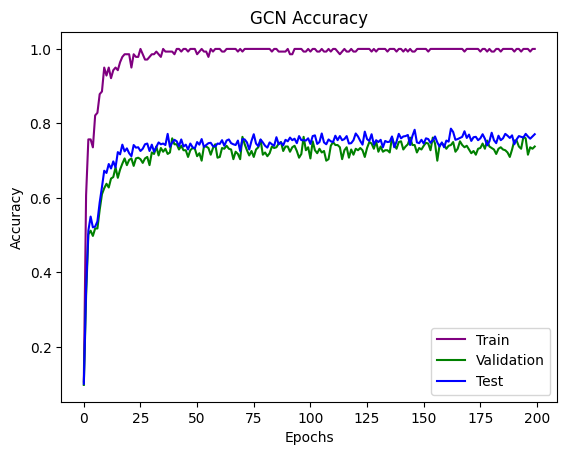

In [9]:
plt.plot(train_accuracies, label="Train", color = "Purple")
plt.plot(val_accuracies, label="Validation", color = "Green")
plt.plot(test_accuracies, label="Test", color = "Blue")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.title("GCN Accuracy")
plt.show()


### QUESTION 4 Interpreting Learned Representations

1. Extract 16-D embeddings & plot with t-SNE

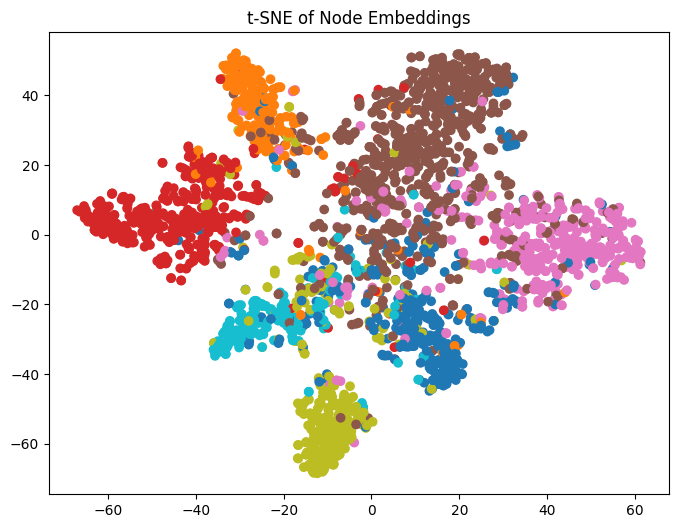

In [13]:
model.eval()
embeddings = model.conv1(data.x, data.edge_index).detach().numpy()
tsne = TSNE(n_components=2)
embeddings_2d = tsne.fit_transform(embeddings)

plt.figure(figsize=(8,6))
plt.scatter(embeddings_2d[:,0], embeddings_2d[:,1], c=data.y.numpy(), cmap='tab10')
plt.title("t-SNE of Node Embeddings")
plt.show()
